# Machine Learning - Group Assignment 3

- Ankita Kokkera - 06032419
- Aria Wang - 06047688
- Tsamara Esperanti Erwin - 06042275
- Jean-Marc Yao - 06055972
- Amer Mulla - 06027165

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import time

1. Load the data set loandata.csv into Python.

In [54]:
loandata = pd.read_csv("loandata.csv")

2. The data set contains some categorical predictors. Sklearn, which you should use for this
exercise, can only handle numerical predictors. Translate the categorical predictors into
numerical predictors. (You may want to look into the pandas function get dummies.)

In [55]:
loandata_numeric = pd.get_dummies(loandata, drop_first=True)

3. Shuffle the data set and split it into 60% training data, 30% validation data and 10% test
data.

In [56]:
# First split (data into 60% train and 40% temp)
train_data, temp_data = train_test_split(
    loandata_numeric,
    test_size = 0.4,
    random_state = 42,
    shuffle = True
)

# Second split (40% temp into 30% validation and 10% test)
val_data, test_data = train_test_split(
    temp_data,
    test_size = 0.25,
    random_state = 42,
    shuffle = True
)

4. Calculate the accuracy of the naive benchmark (majority predictor) on the validation set.

In [57]:
# Separate target variable
y_train = train_data["Default_Yes"]
y_val = val_data["Default_Yes"]

majority_class = y_train.mode()[0]

y_val_pred_naive = [majority_class] * len(y_val)

naive_accuracy = accuracy_score(y_val, y_val_pred_naive)
print("Naive benchmark validatoin accuracy:", naive_accuracy)

Naive benchmark validatoin accuracy: 0.7458745874587459


5. Train a decision tree and calculate the accuracy of this tree on the training and validation set.
Choose an appropriate maximum depth and justify your choice. (Look at the max depth
parameter). All other settings should be kept at default values. What do you think of this
classifier?

In [58]:
X_train = train_data.drop(columns = ["Default_Yes"])
y_train = train_data["Default_Yes"]

X_val = val_data.drop(columns=["Default_Yes"])
y_val = val_data["Default_Yes"]

tree = DecisionTreeClassifier(max_depth = 3, random_state = 42)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_val_pred = tree.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Decision Tree training accuracy:", train_accuracy)
print("Decision Tree validatoin accuracy:", val_accuracy)


Decision Tree training accuracy: 0.8770627062706271
Decision Tree validatoin accuracy: 0.8448844884488449


A tree with `max_depth = 3` was chosen as this is not too high (leading to model complexity and overfitting) and not too low (leading to an overly simplisitc model and underfitting). This depth thus provides a reasonable trade-off between bias and variance.

6. Try a random forest algorithm instead. Use different number of estimators and plot the
accuracy (on training and validation data) as a function of the number of estimators. (Look
at the n estimators parameter).

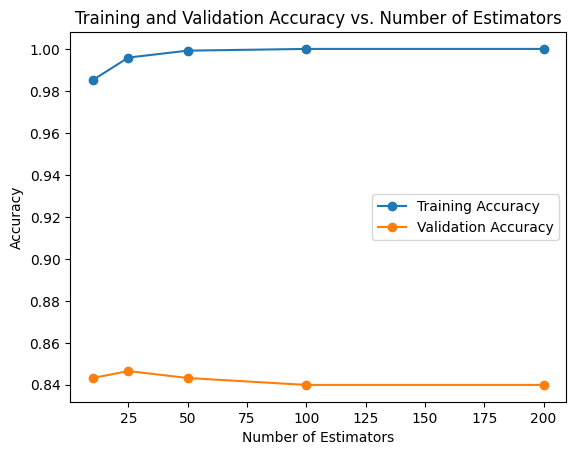

In [59]:
X_train = train_data.drop(columns = ["Default_Yes"])
y_train = train_data["Default_Yes"]

X_val = val_data.drop(columns = ["Default_Yes"])
y_val = val_data["Default_Yes"]

n_estimators_list = [10, 25, 50, 100, 200]

train_accuracies = []
val_accuracies = []

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators = n,
        random_state = 42
    )
    
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    val_pred = rf.predict(X_val)
    
    train_accuracies.append(accuracy_score(y_train, train_pred))
    val_accuracies.append(accuracy_score(y_val, val_pred))

plt.figure()
plt.plot(n_estimators_list, train_accuracies, marker = 'o', label = "Training Accuracy")
plt.plot(n_estimators_list, val_accuracies, marker = 'o', label = "Validation Accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs. Number of Estimators")
plt.legend()
plt.show()

As the number of estimators increase, training accuracy approaches 1, while validation accuracy improves only marginally and then stabilises. This indicates diminishing returns from adding more trees and suggests that larger forests do not substantially improve the performance of the model.

7. Also plot the training time (vs the number of estimators) for the random forest models in
the previous step. What appropriate number of estimators would you choose? Why?

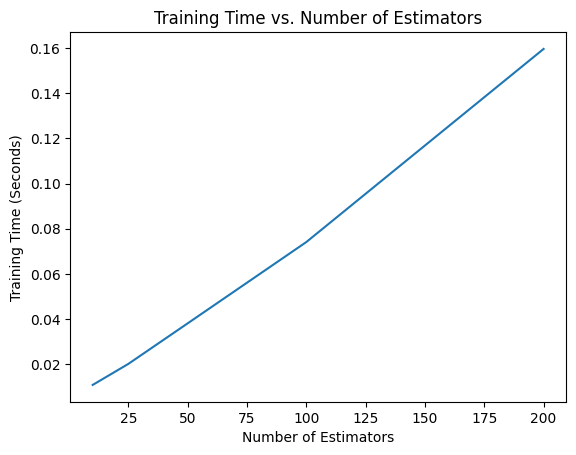

In [60]:
training_times = []

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=42
    )
    
    start_time = time.time()
    rf.fit(X_train, y_train)
    end_time = time.time()
    
    training_times.append(end_time - start_time)

plt.plot(n_estimators_list, training_times)
plt.xlabel("Number of Estimators")
plt.ylabel("Training Time (Seconds)")
plt.title("Training Time vs. Number of Estimators")
plt.show()

Training time increases approximately linearly as the number of estimators increases

8. Compare and explain the performance, interpretability, training time and generalisability of
your decision tree in part 5 to your chosen random forest estimator in part 7.

**Performance**: The random forest outperforms the decision tree on the validation set as it achieves higher accuracy. While the decision tree fits the training data well, its performance on unseen data is weaker, indicating a higher tendency to ocerfit. The ensemble nature of the random forest reduces variance and improves predictive accuracy.

**Interpretability**: The decision tree is highly interpretable as its structure allows predictions to be explained through simple decision rules. In contrast, the random forest is less interpretable because it aggregates predictions from many trees, making individual decisions difficult to interpret.

**Training Time**: The decision tree trains very quickly and requires less compute. The random forest requires more compute, with training time increasing approximately linearly with the number of estimators.

**Generalisability**: The random forest generalises better than the decision tree, as evidenced by its great validation accuracy and reduced sensitivity to noise. The decision tree is more proneto overfitting, whereas the random forest’s averaging mechanism improves robustness on unseen data.

Overall, the decision tree offers simplicity and interpretability, while the random forest provides improved performance and generalisation at the cost of increased training time and reduced interpretability.
